# How to Create Different Tasks

- This notebook is a practical guide to the task-based architecture in spikeRNN. It shows how to work with built-in tasks and how to design your own.


First, make sure the ``spikeRNN`` package is installed

In [205]:
import sys
# !{sys.executable} -m pip install -e ..

Check all the available tasks

In [1]:
from rate.tasks import TaskFactory

available_tasks = TaskFactory.list_available_tasks()
print(f"Available tasks: {available_tasks}")

Available tasks: ['go_nogo', 'xor', 'mante']


### Go-Nogo Task

To create a Go-Nogo Task, you can directly use the task-based API:

In [207]:
from rate import GoNogoTask

settings = {'T': 200, 'stim_on': 20, 'stim_dur': 10, 'delay': 5}

task = GoNogoTask(settings)
stimulus, target, label = task.simulate_trial()

Or use the TaskFactory (where the Go-Nogo task is already instantiated)

In [208]:
# Set up task settings
settings = {'T': 200, 'stim_on': 20, 'stim_dur': 10, 'delay': 5}

# Create a GoNogo task
GoNogoTask = TaskFactory.create_task('go_nogo', settings)
stimulus, target, label = GoNogoTask.simulate_trial()

# Check the task type and label
print(f'  {GoNogoTask}: {GoNogoTask.__class__.__name__} -> label: {label}')

  <rate.tasks.GoNogoTask object at 0x71ef3357c8b0>: GoNogoTask -> label: 0


### XOR Task

Similarly, for XOR task, you can either directly use the task-based API:

In [209]:
from rate import XORTask

settings = {'T': 200, 'stim_on': 20, 'stim_dur': 10, 'delay': 5}

task = XORTask(settings)
stimulus, target, label = task.simulate_trial()

Or use TaskFactory (where XOR task is instantiated)

In [210]:
# Set up task settings
settings = {'T': 200, 'stim_on': 20, 'stim_dur': 10, 'delay': 5}

# Create a GoNogo task
XORTask = TaskFactory.create_task('xor', settings)
stimulus, target, label = XORTask.simulate_trial()

# Check the task type and label
print(f'  {XORTask}: {XORTask.__class__.__name__} -> label: {label}')

  <rate.tasks.XORTask object at 0x71ef348b5ba0>: XORTask -> label: diff


### Mante Task

In [211]:
from rate import ManteTask

settings = {'T': 200, 'stim_on': 20, 'stim_dur': 10, 'delay': 5}

task = ManteTask(settings)
stimulus, target, label = task.simulate_trial()

In [212]:
# Set up task settings
settings = {'T': 200, 'stim_on': 20, 'stim_dur': 10, 'delay': 5}

# Create a GoNogo task
ManteTask = TaskFactory.create_task('mante', settings)
stimulus, target, label = ManteTask.simulate_trial()

# Check the task type and label
print(f'  {ManteTask}: {ManteTask.__class__.__name__} -> label: {label}')

  <rate.tasks.ManteTask object at 0x71ef33587880>: ManteTask -> label: 1


## Adding Custom Tasks

### Example 1: N-Back Working Memory Task

Let's create a more sophisticated custom task - an N-Back working memory task where the network must detect when the current stimulus matches the stimulus from N trials back.


In [213]:
from rate.tasks import AbstractTask
import numpy as np

class NBackTask(AbstractTask):
    """
    N-Back working memory task.
    
    The network must respond when the current stimulus matches 
    the stimulus from N trials back.
    """
    
    def validate_settings(self):
        required_keys = ['T', 'stim_on', 'stim_dur', 'n_back', 'n_stimuli']
        for key in required_keys:
            if key not in self.settings:
                raise ValueError(f"Missing required setting: {key}")
        
        # Validate timing
        if self.settings['stim_on'] + self.settings['stim_dur'] >= self.settings['T']:
            raise ValueError("Stimulus extends beyond trial duration")
        
        # Validate n_back value
        if self.settings['n_back'] < 1:
            raise ValueError("n_back must be at least 1")
            
        # Validate number of stimulus types
        if self.settings['n_stimuli'] < 2:
            raise ValueError("Must have at least 2 different stimuli")
    
    def generate_stimulus(self, seed=False):
        if seed:
            np.random.seed(42)
            
        T = self.settings['T']
        stim_on = self.settings['stim_on']
        stim_dur = self.settings['stim_dur']
        n_stimuli = self.settings['n_stimuli']
        
        # Initialize stimulus matrix (n_stimuli channels × time)
        stimulus = np.zeros((n_stimuli, T))
        
        # Choose a random stimulus type (0 to n_stimuli-1)
        stim_type = np.random.randint(0, n_stimuli)
        
        # Apply stimulus in the appropriate channel
        stimulus[stim_type, stim_on:stim_on+stim_dur] = 1.0
        
        return stimulus, stim_type
    
    def generate_target(self, current_stim, seed=False, stimulus_history=None):
        """
        Generate target based on current stimulus and history.
        
        Args:
            current_stim: Current stimulus type
            seed: Random seed flag
            stimulus_history: List of previous stimulus types
        """
        T = self.settings['T']
        stim_on = self.settings['stim_on']
        stim_dur = self.settings['stim_dur']
        n_back = self.settings['n_back']
        
        # Initialize target (response after stimulus)
        target = np.zeros(T-1)
        response_start = stim_on + stim_dur
        
        # Check if we have enough history and if current matches n-back
        is_match = False
        if stimulus_history and len(stimulus_history) >= n_back:
            target_stimulus = stimulus_history[-n_back]
            is_match = (current_stim == target_stimulus)
        
        # Set target response
        if is_match:
            target[response_start:] = 1.0  # Respond for match
        else:
            target[response_start:] = 0.0  # No response for non-match
            
        return target
    
    def simulate_trial(self, seed=False, stimulus_history=None):
        """
        Simulate a complete trial with history context.
        """
        stimulus, stim_type = self.generate_stimulus(seed=seed)
        target = self.generate_target(stim_type, seed=seed, stimulus_history=stimulus_history)
        
        return stimulus, target, stim_type


In [214]:
# Test the N-Back task
settings = {
    'T': 200,
    'stim_on': 50, 
    'stim_dur': 30,
    'n_back': 2,      # 2-back task
    'n_stimuli': 4    # 4 different stimulus types
}

nback_task = NBackTask(settings)

# Simulate a sequence of trials with history
stimulus_history = []
print("N-Back Task Simulation:")
print("=" * 50)

for trial in range(5):
    stimulus, target, stim_type = nback_task.simulate_trial(stimulus_history=stimulus_history)
    
    # Check if this is a match trial
    is_match = False
    if len(stimulus_history) >= settings['n_back']:
        is_match = (stim_type == stimulus_history[-settings['n_back']])
    
    print(f"Trial {trial+1}: Stimulus={stim_type}, Match={is_match}, Target_mean={target.mean():.1f}")
    
    # Add to history
    stimulus_history.append(stim_type)

print(f"\nStimulus history: {stimulus_history}")
print(f"Final stimulus shape: {stimulus.shape}")
print(f"Final target shape: {target.shape}")


N-Back Task Simulation:
Trial 1: Stimulus=3, Match=False, Target_mean=0.0
Trial 2: Stimulus=3, Match=False, Target_mean=0.0
Trial 3: Stimulus=0, Match=False, Target_mean=0.0
Trial 4: Stimulus=0, Match=False, Target_mean=0.0
Trial 5: Stimulus=3, Match=False, Target_mean=0.0

Stimulus history: [3, 3, 0, 0, 3]
Final stimulus shape: (4, 200)
Final target shape: (199,)


### Example 2: Delayed Match-to-Sample Task

Another classic cognitive task where the network must remember a sample stimulus and then respond when a test stimulus matches it after a delay.


In [215]:
class DelayedMatchToSampleTask(AbstractTask):
    """
    Delayed Match-to-Sample task.
    
    Timeline:
    1. Sample stimulus presentation
    2. Delay period (working memory)
    3. Test stimulus presentation  
    4. Response period (match/no-match decision)
    """
    
    def validate_settings(self):
        required_keys = ['T', 'sample_on', 'sample_dur', 'delay_dur', 'test_on', 'test_dur', 'n_stimuli']
        for key in required_keys:
            if key not in self.settings:
                raise ValueError(f"Missing required setting: {key}")
        
        # Validate timing sequence
        sample_end = self.settings['sample_on'] + self.settings['sample_dur']
        test_start = self.settings['test_on']
        test_end = test_start + self.settings['test_dur']
        
        if sample_end > test_start:
            raise ValueError("Sample stimulus overlaps with test stimulus")
        if test_end >= self.settings['T']:
            raise ValueError("Test stimulus extends beyond trial duration")
        if (test_start - sample_end) < self.settings['delay_dur']:
            raise ValueError("Insufficient delay period")
    
    def generate_stimulus(self, seed=False):
        if seed:
            np.random.seed(42)
            
        T = self.settings['T']
        sample_on = self.settings['sample_on']
        sample_dur = self.settings['sample_dur']
        test_on = self.settings['test_on']
        test_dur = self.settings['test_dur']
        n_stimuli = self.settings['n_stimuli']
        
        # Initialize stimulus matrix (n_stimuli channels × time)
        stimulus = np.zeros((n_stimuli, T))
        
        # Generate sample stimulus
        sample_type = np.random.randint(0, n_stimuli)
        stimulus[sample_type, sample_on:sample_on+sample_dur] = 1.0
        
        # Generate test stimulus (50% chance of match)
        if np.random.rand() < 0.5:
            test_type = sample_type  # Match trial
            is_match = True
        else:
            # Non-match trial - choose different stimulus
            available_stimuli = [i for i in range(n_stimuli) if i != sample_type]
            test_type = np.random.choice(available_stimuli)
            is_match = False
        
        stimulus[test_type, test_on:test_on+test_dur] = 1.0
        
        return stimulus, {'sample': sample_type, 'test': test_type, 'match': is_match}
    
    def generate_target(self, label, seed=False):
        T = self.settings['T']
        test_on = self.settings['test_on']
        test_dur = self.settings['test_dur']
        
        # Response starts after test stimulus
        response_start = test_on + test_dur
        target = np.zeros(T-1)
        
        # Set target based on match/no-match
        if label['match']:
            target[response_start:] = 1.0  # Respond for match
        else:
            target[response_start:] = 0.0  # No response for non-match
            
        return target


In [216]:
# Test the Delayed Match-to-Sample task
dms_settings = {
    'T': 300,
    'sample_on': 30,
    'sample_dur': 20,
    'delay_dur': 50,
    'test_on': 120,
    'test_dur': 20,
    'n_stimuli': 3
}

dms_task = DelayedMatchToSampleTask(dms_settings)

print("Delayed Match-to-Sample Task:")
print("=" * 40)

# Run several trials
for trial in range(3):
    stimulus, target, label = dms_task.simulate_trial(seed=True if trial==0 else False)
    
    print(f"Trial {trial+1}:")
    print(f"  Sample: {label['sample']}, Test: {label['test']}")
    print(f"  Match: {label['match']}, Target response: {target.mean():.1f}")
    print(f"  Stimulus shape: {stimulus.shape}")
    print()


Delayed Match-to-Sample Task:
Trial 1:
  Sample: 2, Test: 0
  Match: False, Target response: 0.0
  Stimulus shape: (3, 300)

Trial 2:
  Sample: 2, Test: 0
  Match: False, Target response: 0.0
  Stimulus shape: (3, 300)

Trial 3:
  Sample: 2, Test: 2
  Match: True, Target response: 0.5
  Stimulus shape: (3, 300)



### Example 3: Registering Custom Tasks with TaskFactory

You can also register your custom tasks with the TaskFactory for easy access:


In [217]:
# Register custom tasks with TaskFactory
TaskFactory._registry['nback'] = NBackTask
TaskFactory._registry['dms'] = DelayedMatchToSampleTask

print("Available tasks after registration:")
print(TaskFactory.list_available_tasks())

# Now you can create tasks using the factory
nback_task_factory = TaskFactory.create_task('nback', {
    'T': 200, 'stim_on': 50, 'stim_dur': 30, 'n_back': 2, 'n_stimuli': 4
})

dms_task_factory = TaskFactory.create_task('dms', {
    'T': 300, 'sample_on': 30, 'sample_dur': 20, 'delay_dur': 50, 
    'test_on': 120, 'test_dur': 20, 'n_stimuli': 3
})

print(f"\nCreated {nback_task_factory.__class__.__name__} via factory")
print(f"Created {dms_task_factory.__class__.__name__} via factory")


Available tasks after registration:
['go_nogo', 'xor', 'mante', 'nback', 'dms']

Created NBackTask via factory
Created DelayedMatchToSampleTask via factory


### Visualization: Understanding Task Structure

Let's visualize the stimulus and target patterns for our custom tasks to better understand their structure:


N-Back Task Visualization:


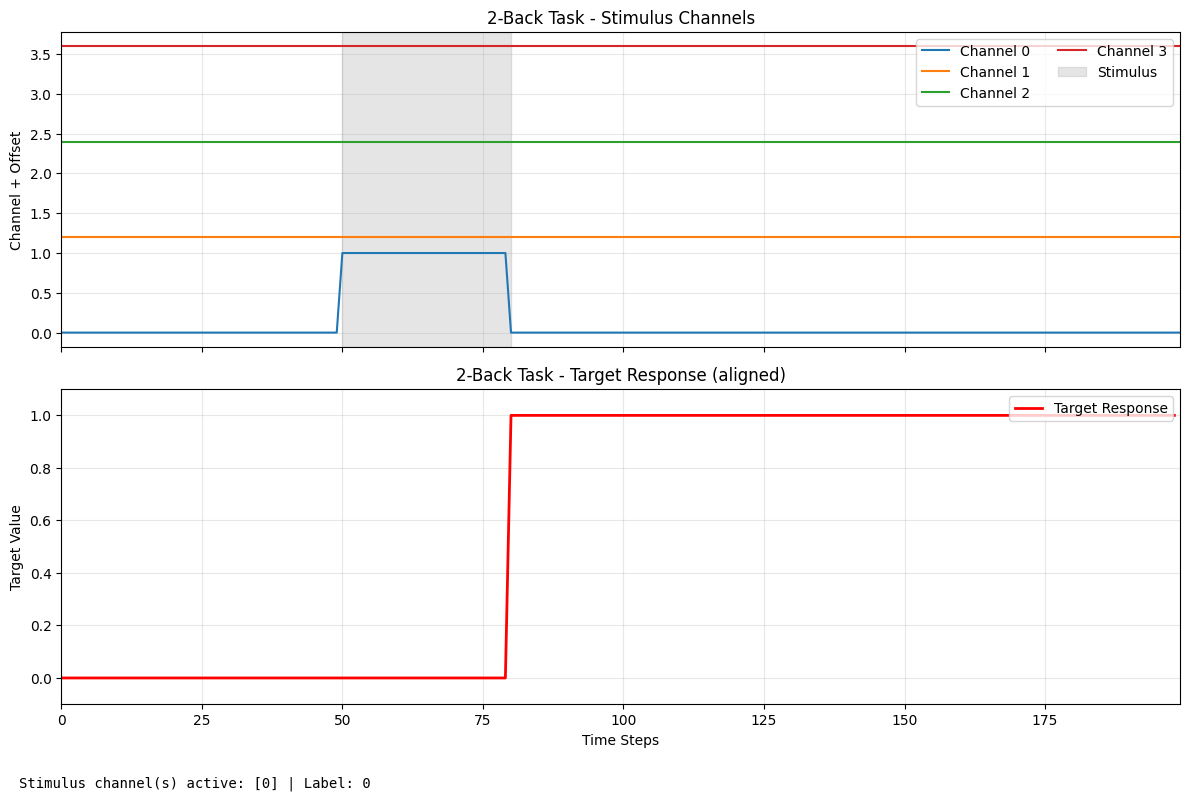

Label or info: 0



In [218]:
import numpy as np
import matplotlib.pyplot as plt

def plot_task_trial(task, title, max_tries=25, **kwargs):
    """Plot stimulus channels and target with annotated task events.
    Tries multiple trials (max_tries) to obtain a non-flat target when needed.
    Aligns target (T-1) to stimulus timeline (T).
    """
    stimulus = target = label = None
    for _ in range(max_tries):
        stimulus, target, label = task.simulate_trial(**kwargs)
        if np.any(target > 0):
            break

    T = stimulus.shape[1]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot stimulus channels with offsets
    for i in range(stimulus.shape[0]):
        ax1.plot(np.arange(T), stimulus[i, :] + i * 1.2, label=f'Channel {i}')

    # Annotate known timing windows based on settings keys
    st = getattr(task, 'settings', {})
    if all(k in st for k in ['stim_on', 'stim_dur']):
        ax1.axvspan(st['stim_on'], st['stim_on'] + st['stim_dur'], color='C7', alpha=0.2, label='Stimulus')
    if all(k in st for k in ['sample_on', 'sample_dur']):
        ax1.axvspan(st['sample_on'], st['sample_on'] + st['sample_dur'], color='C2', alpha=0.2, label='Sample')
    if all(k in st for k in ['test_on', 'test_dur']):
        ax1.axvspan(st['test_on'], st['test_on'] + st['test_dur'], color='C3', alpha=0.2, label='Test')

    ax1.set_title(f'{title} - Stimulus Channels')
    ax1.set_ylabel('Channel + Offset')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', ncol=2)

    # Plot target aligned to stimulus timeline
    ax2.plot(np.arange(T - 1), target, 'r-', linewidth=2, label='Target Response')
    ax2.set_title(f'{title} - Target Response (aligned)')
    ax2.set_ylabel('Target Value')
    ax2.set_xlabel('Time Steps')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_xlim(0, T - 1)
    ax2.legend(loc='upper right')

    # Consistency checks and helpful annotations
    note_lines = []
    # N-Back style label: integer channel
    if isinstance(label, (int, np.integer)) and all(k in st for k in ['stim_on', 'stim_dur']):
        active = np.where(stimulus[:, st['stim_on']:st['stim_on'] + st['stim_dur']].sum(axis=1) > 0)[0]
        note_lines.append(f'Stimulus channel(s) active: {active.tolist()} | Label: {int(label)}')
        if int(label) not in active.tolist():
            note_lines.append('WARNING: label may not match active stimulus channel(s).')
    # DMS label: dict with sample/test/match
    if isinstance(label, dict) and {'sample', 'test', 'match'} <= set(label.keys()):
        note_lines.append(f"Sample={label['sample']}, Test={label['test']}, Match={label['match']}")
    if note_lines:
        fig.text(0.02, 0.01, '\n'.join(note_lines), fontsize=10, family='monospace')

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

    return label

# Plot N-Back task trial (try until a response appears by re-sampling)
print("N-Back Task Visualization:")
nback_label = plot_task_trial(nback_task, "2-Back Task", stimulus_history=[0, 0], max_tries=100)
print(f"Label or info: {nback_label}")
print()


Delayed Match-to-Sample Task Visualization:


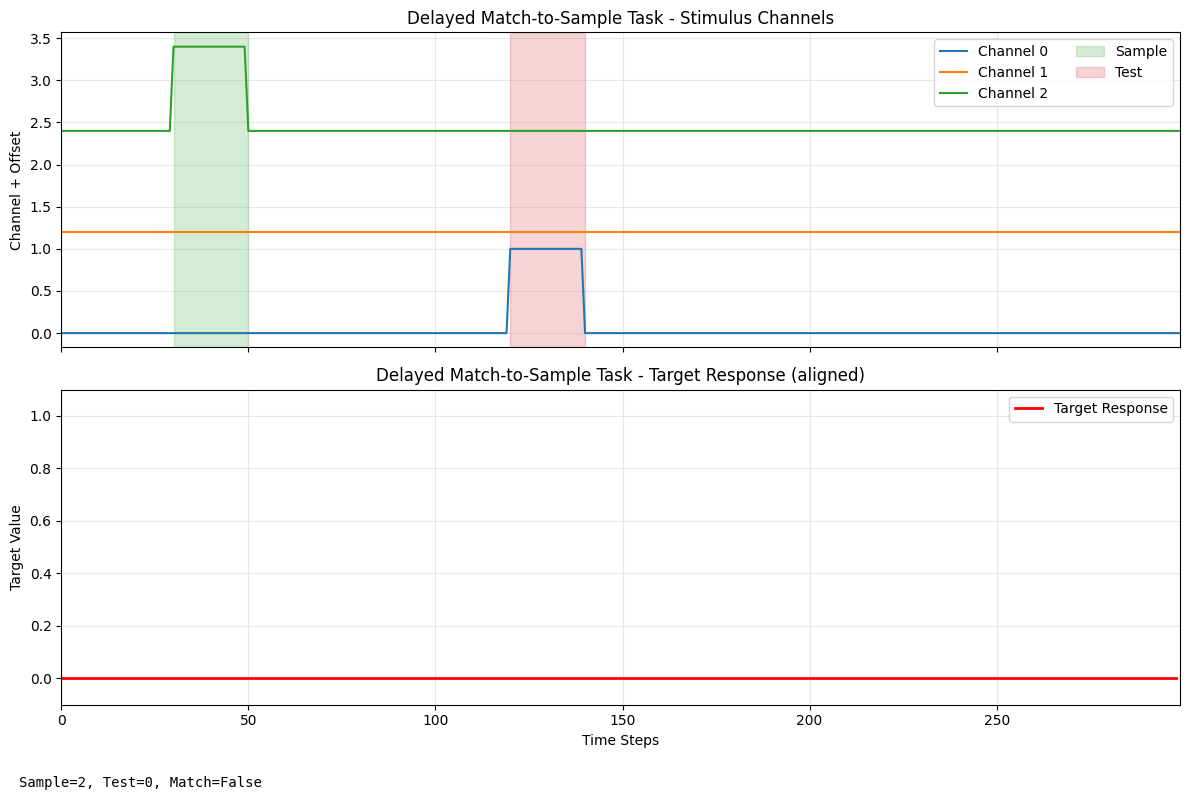

Trial info: {'sample': 2, 'test': np.int64(0), 'match': False}



In [219]:
# Plot Delayed Match-to-Sample task trial
print("Delayed Match-to-Sample Task Visualization:")
dms_label = plot_task_trial(dms_task, "Delayed Match-to-Sample Task", seed=True)
print(f"Trial info: {dms_label}")
print()


### Key Design Principles for Custom Tasks

When creating custom tasks, follow these important principles:

1. **Inherit from AbstractTask**: Always inherit from `AbstractTask` to ensure compatibility
2. **Implement required methods**: 
   - `validate_settings()`: Check that all required parameters are present and valid
   - `generate_stimulus()`: Create the input stimulus pattern
   - `generate_target()`: Create the target output pattern
3. **Use descriptive settings**: Make task parameters configurable through the settings dictionary
4. **Handle edge cases**: Validate timing, stimulus ranges, and other constraints
5. **Document your task**: Include clear docstrings explaining the task logic
6. **Test thoroughly**: Verify that your task generates expected patterns

### Optional: Advanced Features

You can also override the default `simulate_trial()` method if you need custom logic for combining stimulus and target generation, as shown in the N-Back example where we need to track stimulus history.
